In [165]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## data preprocessing - Cleaning

In [166]:
# Load the dataset
data_path = '../data/exl_credit_card_churn_data.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Display first few rows
df.head()

Dataset loaded successfully!
Shape: (1010, 10)


,CustomerID,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,CUST0001,Male,56.0,4.0,0.00,4.0,0.0,0.0,40282.42,1.0
1,CUST0002,NaN,28.0,8.0,67408.01,4.0,0.0,1.0,27333.51,0.0
2,CUST0003,Female,47.0,6.0,1154.97,1.0,0.0,1.0,99514.91,1.0
3,CUST0004,Male,42.0,1.0,0.00,2.0,1.0,1.0,146588.22,0.0
4,CUST0005,Male,64.0,3.0,77109.94,4.0,0.0,0.0,131792.25,0.0


In [167]:
df['Churn'].isna().sum()

np.int64(3)

In [168]:
df['Churn'].value_counts()

Churn
0.0      523
1.0      478
2          3
2.0        2
Maybe      1
Name: count, dtype: int64

In [169]:
# remove the CustomerID column (not needed for analysis)
# df.drop(columns=['CustomerID'], inplace=True)

In [170]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

CustomerID         0
Gender             6
Age                2
Tenure             3
Balance            4
NumOfProducts      4
HasCrCard          2
IsActiveMember     5
EstimatedSalary    1
Churn              3
dtype: int64

In [171]:
# fill the null values
# for gender,Churn,hascrcard,isactivemember -> fill mode
# for age, Tenure,balance,numofproducts,estimatedsalary -> fill mean

df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Age'] = df['Age'].fillna(df['Age'].mean())
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].mean())
df['Balance'] = df['Balance'].fillna(df['Balance'].mean())
df['NumOfProducts'] = df['NumOfProducts'].fillna(df['NumOfProducts'].mean())
df['EstimatedSalary'] = df['EstimatedSalary'].fillna(df['EstimatedSalary'].mean())
df['Churn'] = df['Churn'].fillna(df['Churn'].mode()[0])
df['HasCrCard'] = df['HasCrCard'].fillna(df['HasCrCard'].mode()[0])
df['IsActiveMember'] = df['IsActiveMember'].fillna(df['IsActiveMember'].mode()[0])

# Check for null values again
null_values = df.isnull().sum()
print("\nNull values after filling:")
print(null_values)


Null values after filling:
CustomerID         0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Churn              0
dtype: int64


In [172]:
df['Churn'].value_counts()

Churn
0.0      526
1.0      478
2          3
2.0        2
Maybe      1
Name: count, dtype: int64

In [173]:
from numpy import dtype

columns = df.dtypes.values
dtypes = df.dtypes.index

print("Before fixing object columns:")
for c,d in zip(columns, dtypes):
    # print unique of each object column
    if c == dtype('O') and d not in ['CustomerID']:
        print(f"Column: {d}, Unique Values: {df[d].unique()}")

print("\n")
# Fix columns Gender, HasCrCard, IsActiveMember and Churn
# for Gender = Use title case
# for HasCrCard = Convert to int and slice to either 0 or 1 (if smthing is > 1 and 0 if smthing is < 0)
# for IsActiveMember = Convert to int and slice to either 0 or 1 (if smthing is > 1 and 0 if smthing is < 0)
# for Churn = Convert to int and slice to either 0 or 1 (if smthing is > 1 and 0 if smthing is < 0) and map 'Maybe' to 2 (for now).

df['Gender'] = df['Gender'].str.strip().str.title()
df['HasCrCard'] = df['HasCrCard'].apply(lambda x: 1 if pd.notna(x) and str(x).isdigit() and float(x) > 0 else 0)
df['IsActiveMember'] = df['IsActiveMember'].apply(lambda x: 1 if pd.notna(x) and str(x).isdigit() and float(x) > 0 else 0)
df['Churn'] = df['Churn'].map({'0.0': 0, '1.0': 1, '2.0': 2, '2': 2, 'Maybe': 2})

columns = df.dtypes.values
dtypes = df.dtypes.index
print("After fixing object columns:")
for c,d in zip(columns, dtypes):
    # print unique of each object column
    if c == dtype('O') and d not in ['CustomerID']:
        print(f"Column: {d}, Unique Values: {df[d].unique()}")

Before fixing object columns:
Column: Gender, Unique Values: ['Male' 'Female' 'FEMALE' ' male ' 'MALE' ' Female']
Column: HasCrCard, Unique Values: ['0.0' '1.0' '2.0' 'Yes']
Column: IsActiveMember, Unique Values: ['0.0' '1.0' '-1' 'No' '-1.0']
Column: Churn, Unique Values: ['1.0' '0.0' 'Maybe' '2.0' '2']


After fixing object columns:
Column: Gender, Unique Values: ['Male' 'Female']


In [174]:
df['Churn'].value_counts()
# Since 2 has very less count, we can drop it for now
df = df[df['Churn'] != 2]

df['Churn'].value_counts()

Churn
0    526
1    478
Name: count, dtype: int64

In [175]:
# save the cleaned dataset
df.to_csv('../data/exl_credit_card_churn_data_cleaned.csv', index=False)

## feature eng and scaling

In [176]:
df.head()

,CustomerID,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,CUST0001,Male,56.0,4.0,0.00,4.0,0,0,40282.42,1
1,CUST0002,Female,28.0,8.0,67408.01,4.0,0,0,27333.51,0
2,CUST0003,Female,47.0,6.0,1154.97,1.0,0,0,99514.91,1
3,CUST0004,Male,42.0,1.0,0.00,2.0,0,0,146588.22,0
4,CUST0005,Male,64.0,3.0,77109.94,4.0,0,0,131792.25,0


In [177]:
df.drop(columns=['CustomerID'], inplace=True)


In [178]:
df.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,Male,56.0,4.0,0.00,4.0,0,0,40282.42,1
1,Female,28.0,8.0,67408.01,4.0,0,0,27333.51,0
2,Female,47.0,6.0,1154.97,1.0,0,0,99514.91,1
3,Male,42.0,1.0,0.00,2.0,0,0,146588.22,0
4,Male,64.0,3.0,77109.94,4.0,0,0,131792.25,0


In [179]:
# Check using IQR for outliers in 'Balance', 'EstimatedSalary', 'Age', 'Tenure'
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_balance = detect_outliers_iqr(df, 'Balance')
outliers_estimated_salary = detect_outliers_iqr(df, 'EstimatedSalary')
outliers_age = detect_outliers_iqr(df, 'Age')
outliers_tenure = detect_outliers_iqr(df, 'Tenure')

# make a set of index of outliers
outliers_indices = set(outliers_balance.index) | set(outliers_estimated_salary.index) | set(outliers_age.index) | set(outliers_tenure.index)
print(f"Total number of outlier indices: {len(outliers_indices)}")


print(f"Outliers in Balance: {outliers_balance}")
print(f"Outliers in EstimatedSalary: {outliers_estimated_salary}")
print(f"Outliers in Age: {outliers_age}")
print(f"Outliers in Tenure: {outliers_tenure}")

# remove the outlier
df = df.drop(index=outliers_indices)

# save the df
df.to_csv('../data/exl_credit_card_churn_data_cleaned_1.csv', index=False)



Total number of outlier indices: 11
Outliers in Balance:      Gender   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
766  Female  70.0     2.0  9999999.0            2.0          0   
869    Male  68.0     7.0  9999999.0            4.0          0   

     IsActiveMember  EstimatedSalary  Churn  
766               0         91068.04      0  
869               0        140987.39      1  
Outliers in EstimatedSalary:      Gender   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
152  Female  53.0     4.0   33240.76            3.0          0   
631  Female  69.0    10.0   86069.80            4.0          0   
761  Female  64.0    10.0  113314.68            4.0          0   

     IsActiveMember  EstimatedSalary  Churn  
152               0       10000000.0      1  
631               0       10000000.0      0  
761               0       10000000.0      0  
Outliers in Age:      Gender    Age  Tenure    Balance  NumOfProducts  HasCrCard  \
22   Female  120.0    10.0  192527.01       

In [180]:
# feature Engineering
# Change balance to 
# age -> use bins 0,25,35,50,100 -> young, adult, middle, senior
# balancecategory (balance)-> -1, 0, 50000, 100000, float(inf) -> Zero, Low, Medium, High
# balance per product -> balance / numofproduct + 1
# tenure-age ratio (Loyalty relative to life stage)


df_feat_eng = df.copy()
# Create age bins
df['AgeCategory'] = pd.cut(df['Age'], bins=[0, 25, 35, 50, 100], labels=['Young', 'Adult', 'Middle', 'Senior'])
# Create balance categories
df['BalanceCategory'] = pd.cut(df['Balance'], bins=[-1, 0, 50000, 100000, np.inf], labels=['Zero', 'Low', 'Medium', 'High'])
# Create balance per product
df['BalancePerProduct'] = df['Balance'] / (df['NumOfProducts'] + 1)
# Create tenure-age ratio
df['TenureAgeRatio'] = df['Tenure'] / (df['Age'] + 1)

df.head()

,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,AgeCategory,BalanceCategory,BalancePerProduct,TenureAgeRatio
0,Male,56.0,4.0,0.00,4.0,0,0,40282.42,1,Senior,Zero,0.000,0.070175
1,Female,28.0,8.0,67408.01,4.0,0,0,27333.51,0,Adult,Medium,13481.602,0.275862
2,Female,47.0,6.0,1154.97,1.0,0,0,99514.91,1,Middle,Low,577.485,0.125000
3,Male,42.0,1.0,0.00,2.0,0,0,146588.22,0,Middle,Zero,0.000,0.023256
4,Male,64.0,3.0,77109.94,4.0,0,0,131792.25,0,Senior,Medium,15421.988,0.046154


In [181]:
# Convert categorical columns to numerical use one-hot encodder
df = pd.get_dummies(df, columns=['Gender', 'AgeCategory', 'BalanceCategory'], drop_first=True)
# Convert Churn to categorical
df['Churn'] = df['Churn'].astype('category')

# Use min-max sclaer on ['Balance', 'EstimatedSalary', 'Age', 'Tenure', 'NumOfProducts', 'BalancePerProduct', 'TenureAgeRatio']
from sklearn.preprocessing import MinMaxScaler
columns_to_scale = ['Balance', 'EstimatedSalary', 'Age', 'Tenure', 'NumOfProducts', 'BalancePerProduct', 'TenureAgeRatio']
scaler_bal = MinMaxScaler()
scaler_estimated_salary = MinMaxScaler()
scaler_age = MinMaxScaler()
scaler_tenure = MinMaxScaler()
scaler_num_of_products = MinMaxScaler()
scaler_balance_per_product = MinMaxScaler()
scaler_tenure_age_ratio = MinMaxScaler()

df['Balance'] = scaler_bal.fit_transform(df[['Balance']])
df['EstimatedSalary'] = scaler_estimated_salary.fit_transform(df[['EstimatedSalary']])
df['Age'] = scaler_age.fit_transform(df[['Age']])
df['Tenure'] = scaler_tenure.fit_transform(df[['Tenure']])
df['NumOfProducts'] = scaler_num_of_products.fit_transform(df[['NumOfProducts']])
df['BalancePerProduct'] = scaler_balance_per_product.fit_transform(df[['BalancePerProduct']])
df['TenureAgeRatio'] = scaler_tenure_age_ratio.fit_transform(df[['TenureAgeRatio']])


## EDA analysis

In [182]:
df_eda = pd.read_csv('../data/exl_credit_card_churn_data_cleaned.csv')
df_eda.head()

,CustomerID,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,CUST0001,Male,56.0,4.0,0.00,4.0,0,0,40282.42,1
1,CUST0002,Female,28.0,8.0,67408.01,4.0,0,0,27333.51,0
2,CUST0003,Female,47.0,6.0,1154.97,1.0,0,0,99514.91,1
3,CUST0004,Male,42.0,1.0,0.00,2.0,0,0,146588.22,0
4,CUST0005,Male,64.0,3.0,77109.94,4.0,0,0,131792.25,0


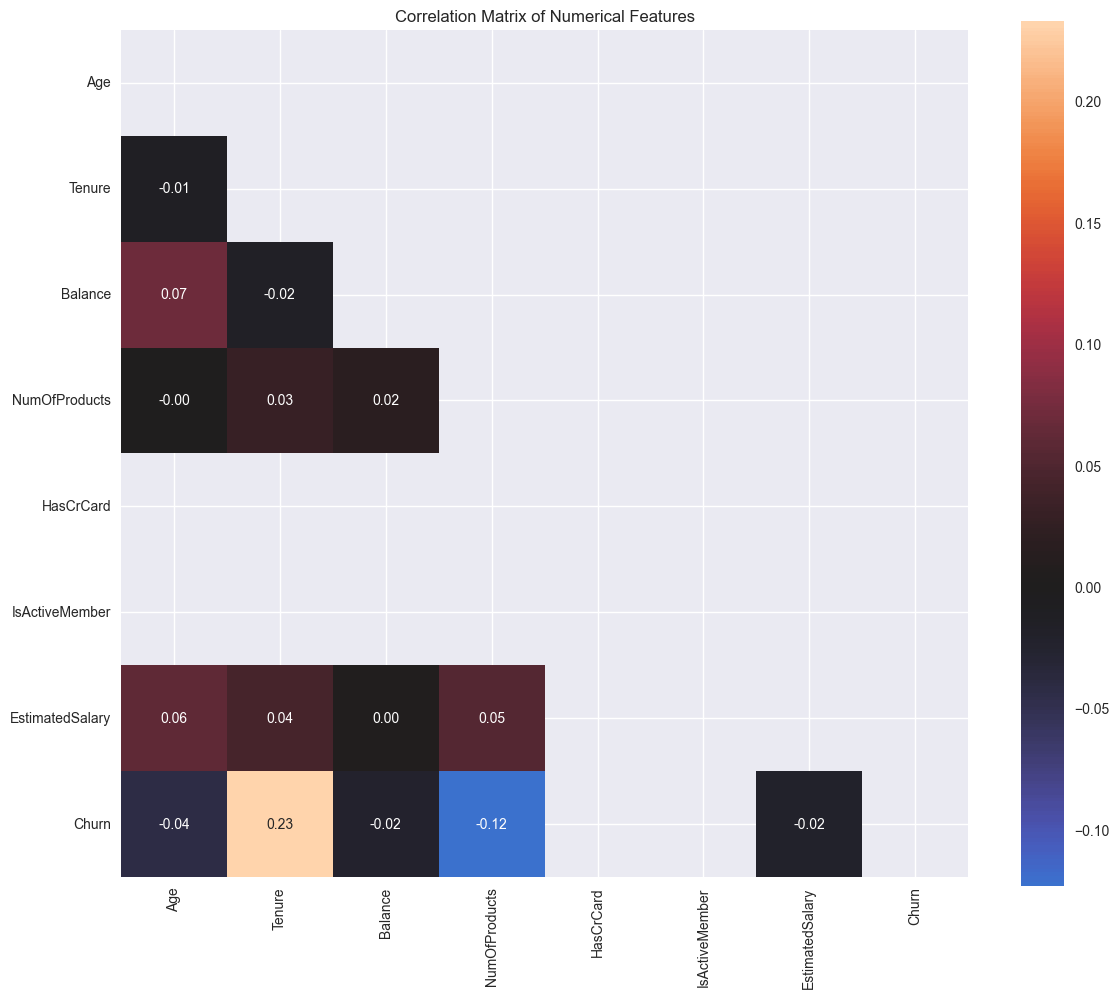

In [183]:
numerical_cols = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Churn']
correlation_matrix = df_eda[numerical_cols].corr()
churn_corr = correlation_matrix['Churn'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create basic heatmap
sns.heatmap(correlation_matrix, 
    mask=mask,
    annot=True, 
    center=0,
    square=True,
    fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

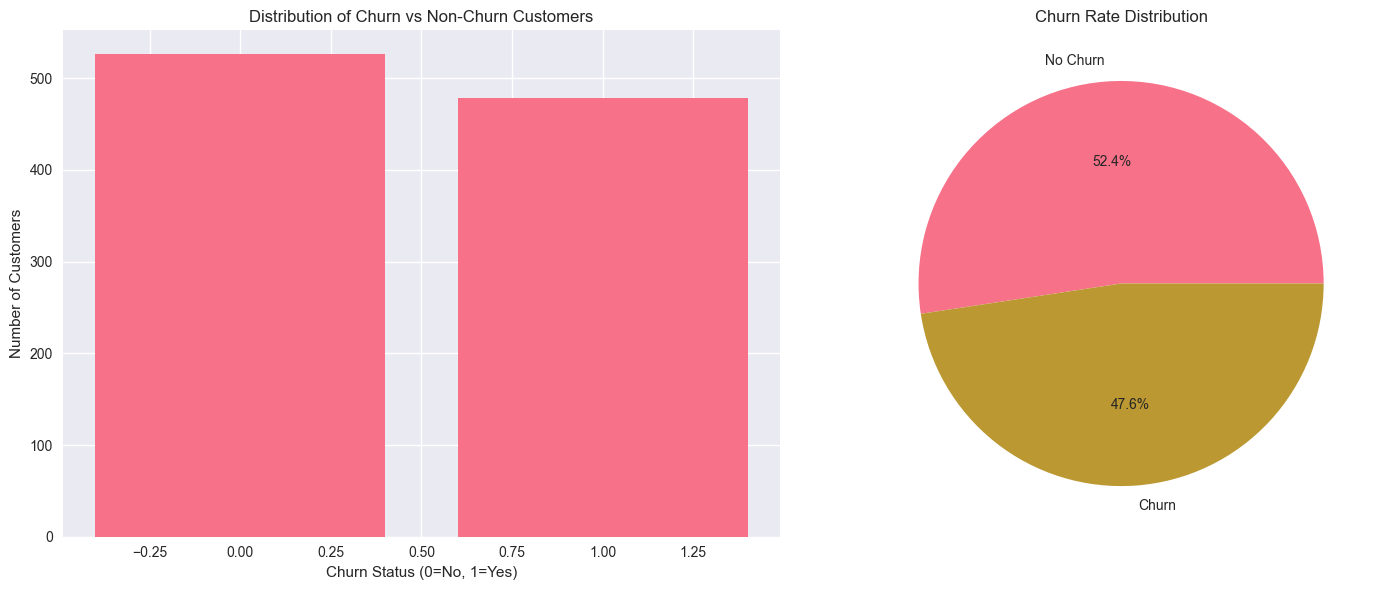

In [184]:
# 1. Churn Distribution Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
churn_counts = df_eda['Churn'].value_counts()
axes[0].bar(churn_counts.index, churn_counts.values)
axes[0].set_title('Distribution of Churn vs Non-Churn Customers')
axes[0].set_xlabel('Churn Status (0=No, 1=Yes)')
axes[0].set_ylabel('Number of Customers')

# Pie chart
churn_percentages = df_eda['Churn'].value_counts(normalize=True) * 100
axes[1].pie(churn_percentages.values, labels=['No Churn', 'Churn'], autopct='%1.1f%%')
axes[1].set_title('Churn Rate Distribution')

plt.tight_layout()
plt.show()

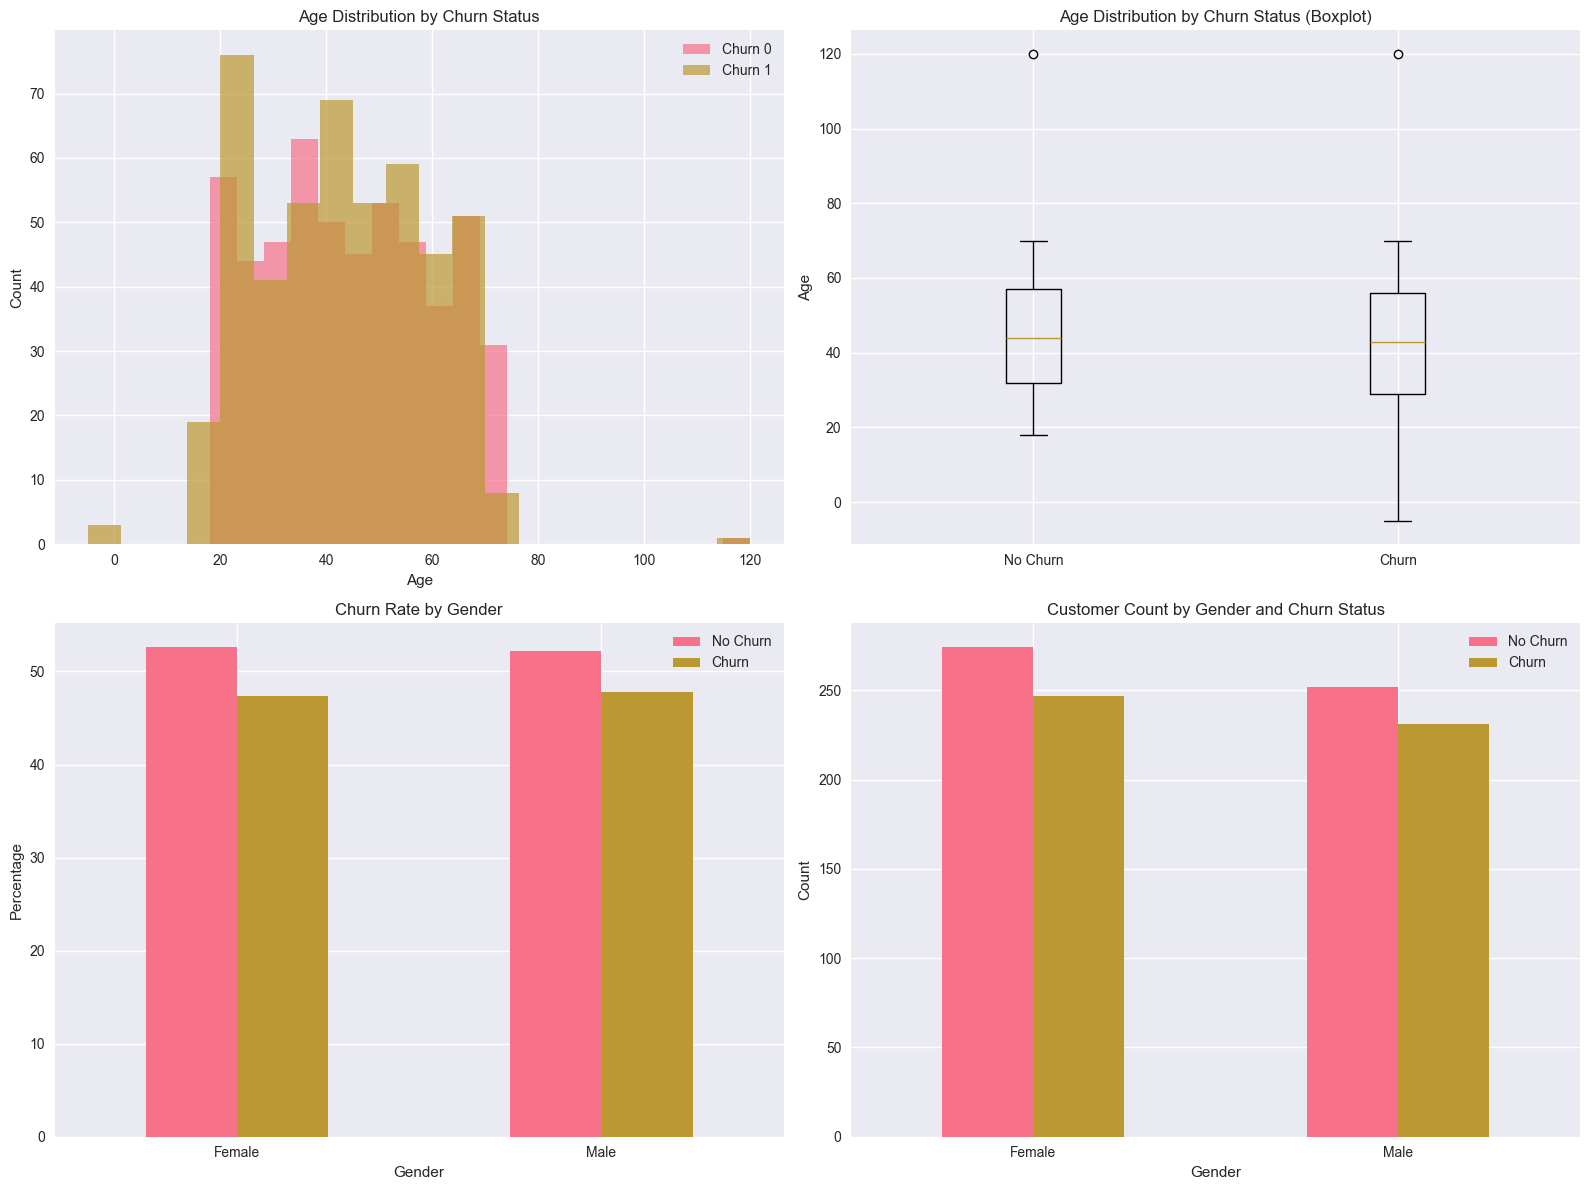

In [185]:
# 2. Age and Gender Analysis by Churn
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Age distribution by churn
for churn_val in [0, 1]:
    subset = df_eda[df_eda['Churn'] == churn_val]
    axes[0, 0].hist(subset['Age'], alpha=0.7, label=f'Churn {churn_val}', bins=20)
axes[0, 0].set_title('Age Distribution by Churn Status')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()

# Age boxplot by churn
churn_0_ages = df_eda[df_eda['Churn'] == 0]['Age']
churn_1_ages = df_eda[df_eda['Churn'] == 1]['Age']
axes[0, 1].boxplot([churn_0_ages, churn_1_ages], labels=['No Churn', 'Churn'])
axes[0, 1].set_title('Age Distribution by Churn Status (Boxplot)')
axes[0, 1].set_ylabel('Age')

# Gender distribution by churn
gender_churn = pd.crosstab(df_eda['Gender'], df_eda['Churn'], normalize='index') * 100
gender_churn.plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Churn Rate by Gender')
axes[1, 0].set_xlabel('Gender')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(['No Churn', 'Churn'])
axes[1, 0].tick_params(axis='x', rotation=0)

# Gender count by churn
gender_counts = pd.crosstab(df_eda['Gender'], df_eda['Churn'])
gender_counts.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Customer Count by Gender and Churn Status')
axes[1, 1].set_xlabel('Gender')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['No Churn', 'Churn'])
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()